## 7. Gaussian Mixture Model (GMM)

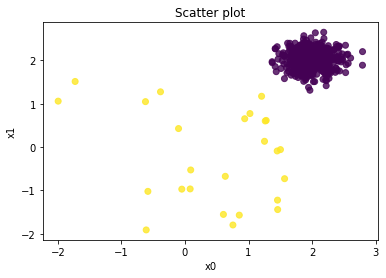

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyod.utils.data import generate_data
contamination = 0.05 # percentage of outliers
n_train = 500       # number of training points
n_test = 500        # number of testing points
n_features = 6      # number of features
X_train, X_test, y_train, y_test = generate_data(
    n_train=n_train, 
    n_test=n_test, 
    n_features= n_features, 
    contamination=contamination, 
    random_state=123)

# Make the 2d numpy array a pandas dataframe for each manipulation 
X_train_pd = pd.DataFrame(X_train)
    
# Plot
plt.scatter(X_train_pd[0], X_train_pd[1], c=y_train, alpha=0.8)
plt.title('Scatter plot')
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

### Step 1: Build the model

In [7]:
from pyod.models.gmm import GMM
gmm = GMM(n_components=4, contamination=0.05) 
gmm.fit(X_train)

# Training data
y_train_scores = gmm.decision_function(X_train)
y_train_pred = gmm.predict(X_train)

# Test data
y_test_scores = gmm.decision_function(X_test)
y_test_pred = gmm.predict(X_test) # outlier labels (0 or 1)

def count_stat(vector):
    # Because it is '0' and '1', we can run a count statistic. 
    unique, counts = np.unique(vector, return_counts=True)
    return dict(zip(unique, counts))

print("The training data:", count_stat(y_train_pred))
print("The training data:", count_stat(y_test_pred))
# Threshold for the defined comtanimation rate
print("The threshold for the defined comtanimation rate:" , gmm.threshold_)

The training data: {0: 475, 1: 25}
The training data: {0: 468, 1: 32}
The threshold for the defined comtanimation rate: 4.944167378942807


In [8]:
gmm.get_params()

{'contamination': 0.05,
 'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 4,
 'n_init': 1,
 'precisions_init': None,
 'random_state': None,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'warm_start': False,
 'weights_init': None}

### Step 2: Determine the threshold

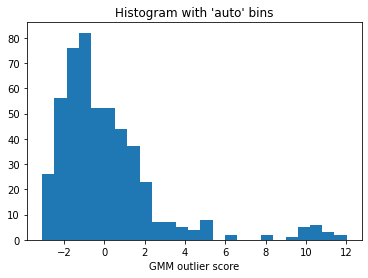

In [9]:
import matplotlib.pyplot as plt
plt.hist(y_train_scores, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.xlabel('GMM outlier score')
plt.show()

### Step 3: Descriptive statistics

In [10]:
threshold = gmm.threshold_ # Or other value from the above histogram

def descriptive_stat_threshold(df,pred_score, threshold):
    # Let's see how many '0's and '1's.
    df = pd.DataFrame(df)
    df['Anomaly_Score'] = pred_score
    df['Group'] = np.where(df['Anomaly_Score']< threshold, 'Normal', 'Outlier')

    # Now let's show the summary statistics:
    cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns={'Anomaly_Score':'Count'})
    cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100 # The count and count %
    stat = df.groupby('Group').mean().round(2).reset_index() # The avg.
    stat = cnt.merge(stat, left_on='Group',right_on='Group') # Put the count and the avg. together
    return (stat)

descriptive_stat_threshold(X_train,y_train_scores, threshold)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,475,95.0,1.99,2.00,1.99,1.98,2.00,1.97,-0.34
1,Outlier,25,5.0,0.63,-0.04,-0.10,0.08,0.16,0.30,9.12


In [11]:
Actual_pred = pd.DataFrame({'Actual': y_test, 'Anomaly_Score': y_test_scores})
Actual_pred['Pred'] = np.where(Actual_pred['Anomaly_Score']< threshold,0,1)
pd.crosstab(Actual_pred['Actual'],Actual_pred['Pred'])

Pred,0,1
Actual,,
0.0,468,7
1.0,0,25


### Averages

In [14]:
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
from pyod.models.gmm import GMM

# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)

# Test a range of clusters from 2 to 8. There will be 7 models.
n_clf = 7
k_list = [2, 3, 4, 5, 6, 7, 8]
n_clf = len(k_list)
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])

# Modeling
for i in range(n_clf):
    k = k_list[i]
    gmm = GMM(n_components = k, contamination=0.05) 
    gmm.fit(X_train_norm)
    # Store the results in each column:
    train_scores[:, i] = gmm.decision_function(X_train_norm) 
    test_scores[:, i] = gmm.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

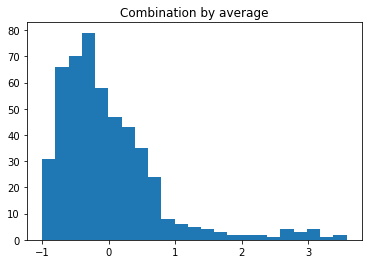

In [15]:
# Combination by average
# The test_scores_norm is 500 x 8. The "average" function will take the average of the 8 columns. The result "y_by_average" is a single column: 
y_train_by_average = average(train_scores_norm)
y_test_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_train_by_average, bins='auto') # arguments are passed to np.histogram
plt.title("Combination by average")
plt.show()

In [28]:
descriptive_stat_threshold(X_train,y_train_by_average, 2.0)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,481,96.2,1.97,1.99,1.97,1.97,1.97,1.97,-0.11
1,Outlier,19,3.8,0.69,-0.26,-0.38,-0.48,0.26,-0.24,2.80


In [27]:
descriptive_stat_threshold(X_test,y_test_by_average, 2.0)

,Group,Count,Count %,0,1,2,3,4,5,Anomaly_Score
0,Normal,472,94.4,2.01,2.01,2.01,1.99,2.01,2.00,-0.09
1,Outlier,28,5.6,0.24,-0.25,0.03,0.18,0.15,0.31,21.87
